# A simple experimental scenario

[Simon Dobson](mailto:simon.dobson@st-andrews.ac.uk) <br>
School of Computer Science, University of St Andrews, Scotland UK

## Introduction

Let's consider a simple scenario of sensing: a grid of sample points (of rain, for the sake of argument), equally-spaced within a rectangular area. We'll then interpolate these samples at a finer resolution to show how the samples are used to drive the interpolation function, represented as a tensor. We'll then explore what happewns when the samples are degraded by randomly removing some proportion of them, and see whether we can use the tensor to derive some insight into the effects of such degradation, and of the effects of errors.

In [1]:
from os.path import exists
from copy import deepcopy
import numpy
from geopandas import GeoDataFrame, GeoSeries, read_file

from sensor_placement import *
from sensor_placement.data import *
from sensor_placement.matplotlib import *

import shapely
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint, shape
from shapely.ops import cascaded_union, nearest_points
from shapely.affinity import translate

import logging
logging.basicConfig(level=logging.INFO)

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm, ListedColormap, to_rgba
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle

In [2]:
rng = numpy.random.default_rng()

## The full-resolution sample grid

For our scenario, we'll use a regular grid of samples five on a side, and an interpolation grid 100 on a side, sitting within a unit square.

In [3]:
samplesPer = 5
pointsPer = 100

nSamples = samplesPer * samplesPer
nPoints = pointsPer * pointsPer

In [4]:
dx = 1 / (samplesPer + 1)
points = []
for y in range(samplesPer):
    for x in range(samplesPer):
        points.append(Point(((x + 1) * dx, (samplesPer - y) * dx)))

df_samples = GeoDataFrame(points, columns=['geometry'])

In [5]:
dx = 1 / (pointsPer + 1)
xs = [ (x + 1) * dx for x in range(pointsPer)]
ys = [ (pointsPer - y) * dx for y in range(pointsPer)]

In [6]:
boundary = Polygon([Point(0.0, 0.0),
                    Point(0.0, 1.0),
                    Point(1.0, 1.0),
                    Point(1.0, 0.0)])

From this we can create a natural nearewst-neighbour interpolation tensor. 

In [7]:
if exists('datasets/tensor_fullresolution.nc'):
    tensor_fullresolution = NNNI.load('datasets/tensor_fullresolution.nc')
else:
    tensor_fullresolution = NNNI(df_samples, boundary, xs, ys)
    tensor_fullresolution.save('datasets/tensor_fullresolution.nc')

INFO:sensor_placement:Tensor will use up to 1 core
INFO:sensor_placement:Created Voronoi diagram in 0.00s
INFO:sensor_placement:Loaded tensor to datasets/tensor_fullresolution.nc in 0.00s


The scenario is shown below, with crosses indicating sample points.

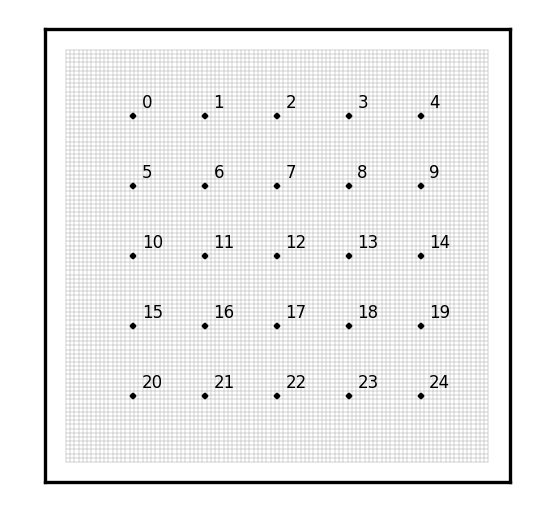

In [8]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

for y in ys:
    ax.plot(xs, [y] * len(xs), color='0.6', linewidth=0.1)
for x in ys:
    ax.plot([x] * len(xs), ys, color='0.6', linewidth=0.1)
    
drawSampleLabels(tensor_fullresolution, ax=ax, include_sample_indices=False)

_ = plt.show()

## Ground truth

We now need an array of samples at the full sampling resolution. We construct this by assigning values to the sample points, both above and below a baseline value.

In [104]:
samples = numpy.full((nSamples,), fill_value=5, dtype=numpy.float64)

samples[0] = 20
samples[2] = 15
samples[3] = 12
samples[4] = 15
samples[5] = 10
samples[1] = 10
samples[10] = 8
samples[13] = 35
samples[15] = 16
samples[16] = 5
samples[20] = 22
samples[21] = 25
samples[24] = 1

We can show these samples as colour blobs, without any interpolation.

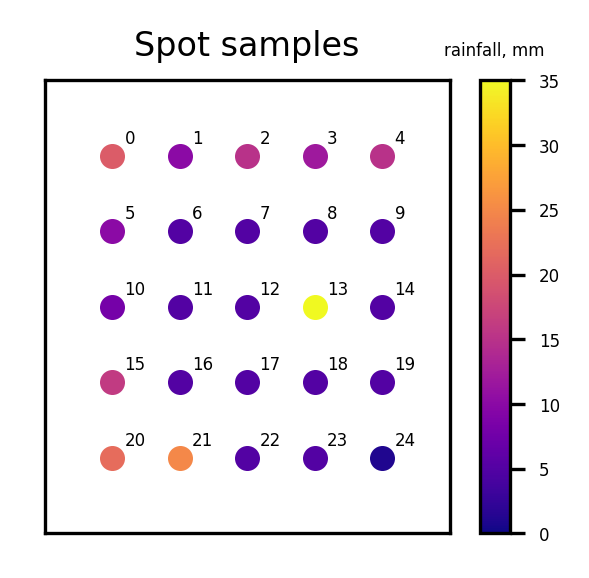

In [10]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

drawSamples(tensor_fullresolution, samples, ax=ax, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')

ax.set_title('Spot samples', fontsize=8)

_ = plt.show()

Interpolating these samples involves applying the tensor to the vector of samples, yielding a grid of interpolated values. We also include the Voronoi cell boundaries.

INFO:sensor_placement:Applied tensor in 0.00s


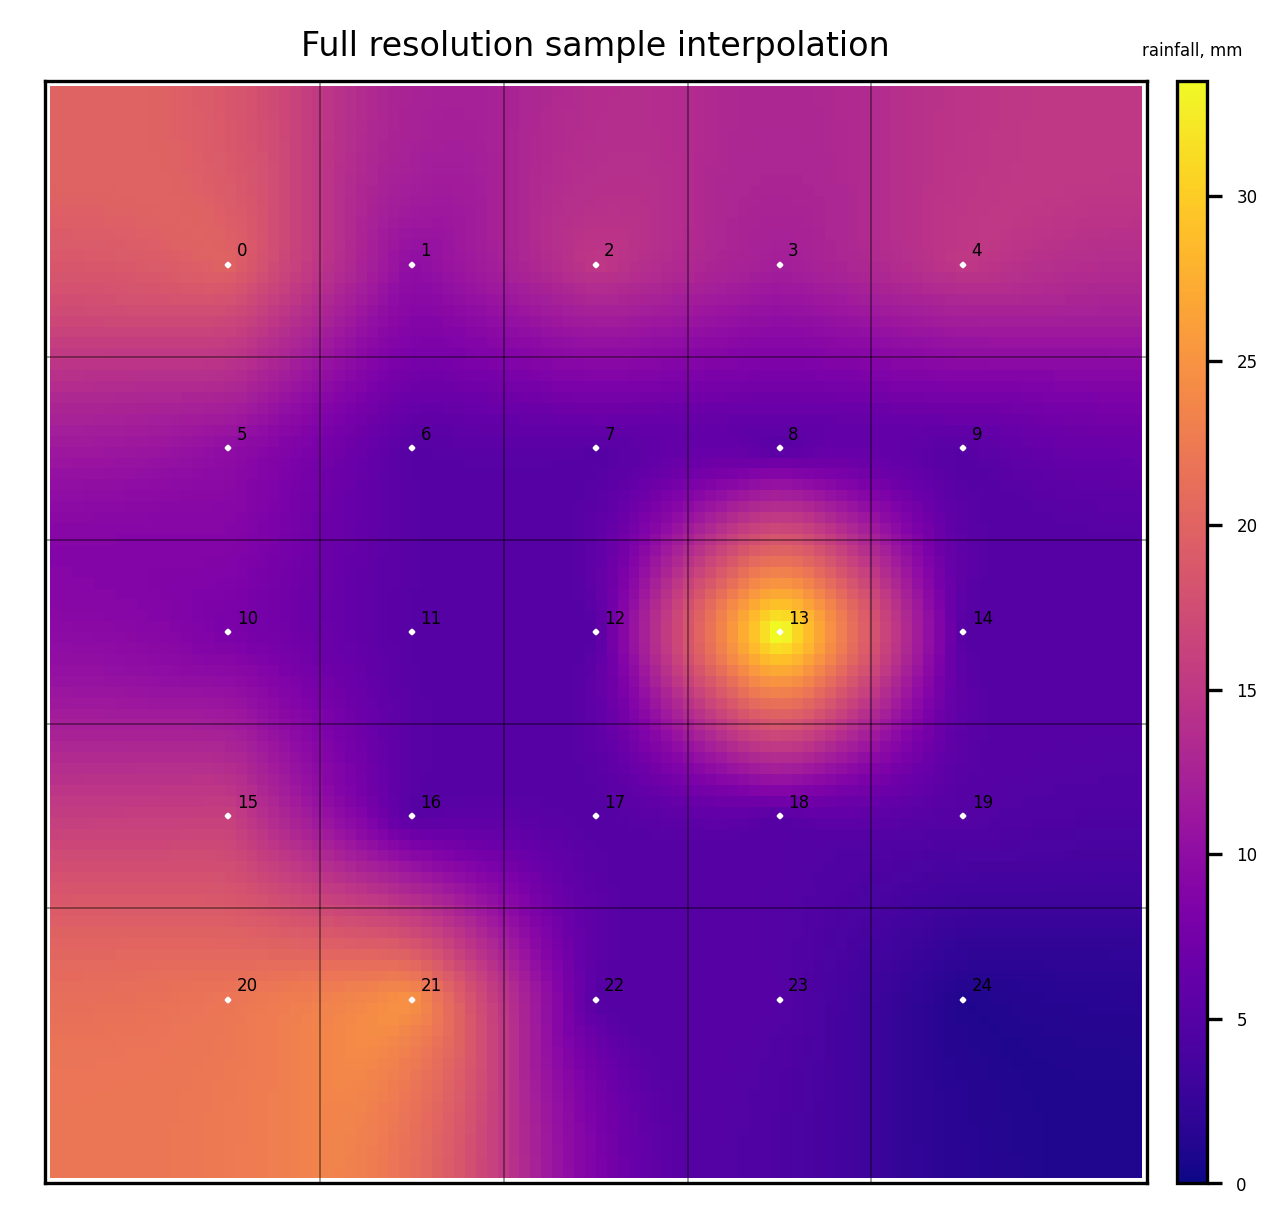

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

_, _, norm = drawInterpolation(tensor_fullresolution, samples, ax=ax, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_fullresolution, ax=ax)
drawSampleLabels(tensor_fullresolution, ax=ax, color='w', include_sample_indices=False)

ax.set_title('Full resolution sample interpolation', fontsize=8)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

_ = plt.show()

## Remove 40% of samples

Now remove 40% of the sample points at random, leaving 60% for interpolation. The removal process removes samples from the sample vector, and removes the corresponding samples from the tensor.

In [105]:
if exists('datasets/tensor_60.nc'):
    tensor_60 = NNNI.load('datasets/tensor_60.nc')
    retain_60 = list(tensor_60._samples.index)
    samples_60 = samples[retain_60]    
else:
    retain_60 = sorted(numpy.random.choice(range(len(samples)), int(len(samples) * 0.6), replace=False))
    remove_60 = sorted(list(set(range(len(samples))) - set(retain_60)))

    samples_60 = samples[retain_60]

    tensor_60 = deepcopy(tensor_fullresolution)
    for i in remove_60:
        tensor_60.removeSample(i)
        
    tensor_60.save('datasets/tensor_60.nc')

INFO:sensor_placement:Tensor will use up to 1 core
INFO:sensor_placement:Created Voronoi diagram in 0.00s
INFO:sensor_placement:Loaded tensor to datasets/tensor_60.nc in 0.00s


Plotting the results from the degraded sample shows a sigfnificantly different pattern, as one would expect. (We label the sample points with their index in the sample vector and their sample identifier (from the full-rewsolution vecotr) in brackets, together with the new Voronoi cells.)

INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


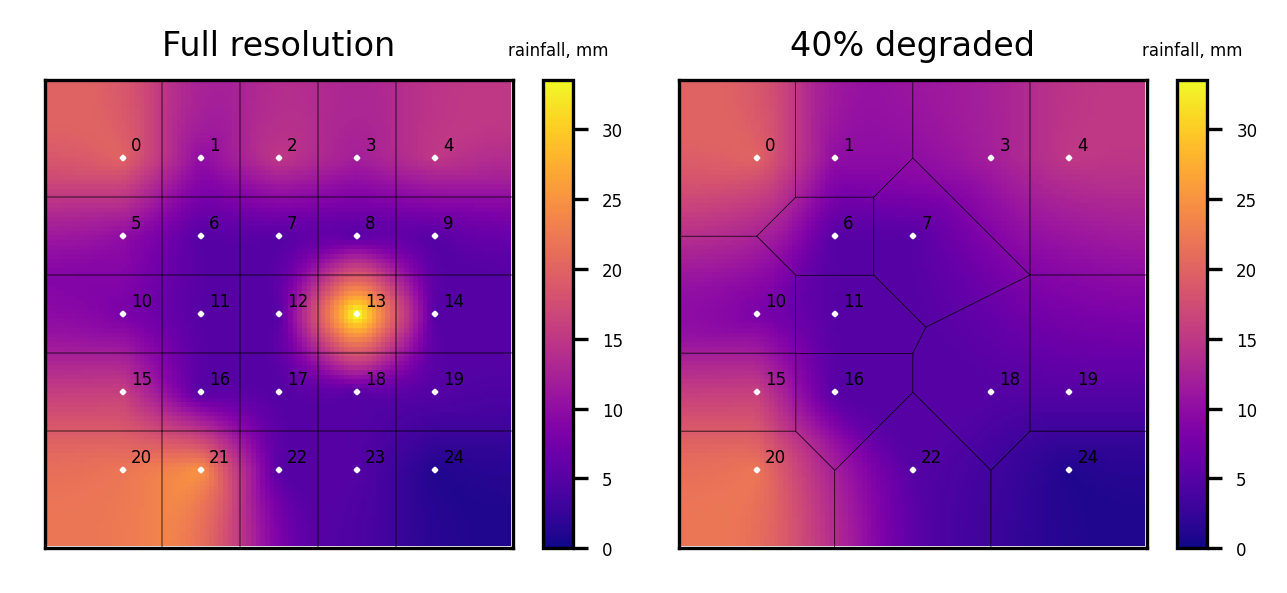

In [13]:
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(1, 2, 1, xticks=[], yticks=[])
drawInterpolation(tensor_fullresolution, samples, ax=ax1, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_fullresolution, ax=ax1)
drawSampleLabels(tensor_fullresolution, ax=ax1, color='w', include_sample_indices=False)
ax1.set_title('Full resolution', fontsize=8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])

ax2 = plt.subplot(1, 2, 2, xticks=[], yticks=[])
drawInterpolation(tensor_60, samples_60, ax=ax2, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_60, ax=ax2)
drawSampleLabels(tensor_60, ax=ax2, color='w', include_sample_indices=-False)
ax2.set_title('40% degraded', fontsize=8)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])

_ = plt.show()

We can plot the difference in temperature between these two interpolations, with yellows indicating that the full-resolution sample is hotter and blues that the degraded resolution is hotter. 

In [14]:
g_diff = tensor_fullresolution.apply(samples) - tensor_60.apply(samples_60)

INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


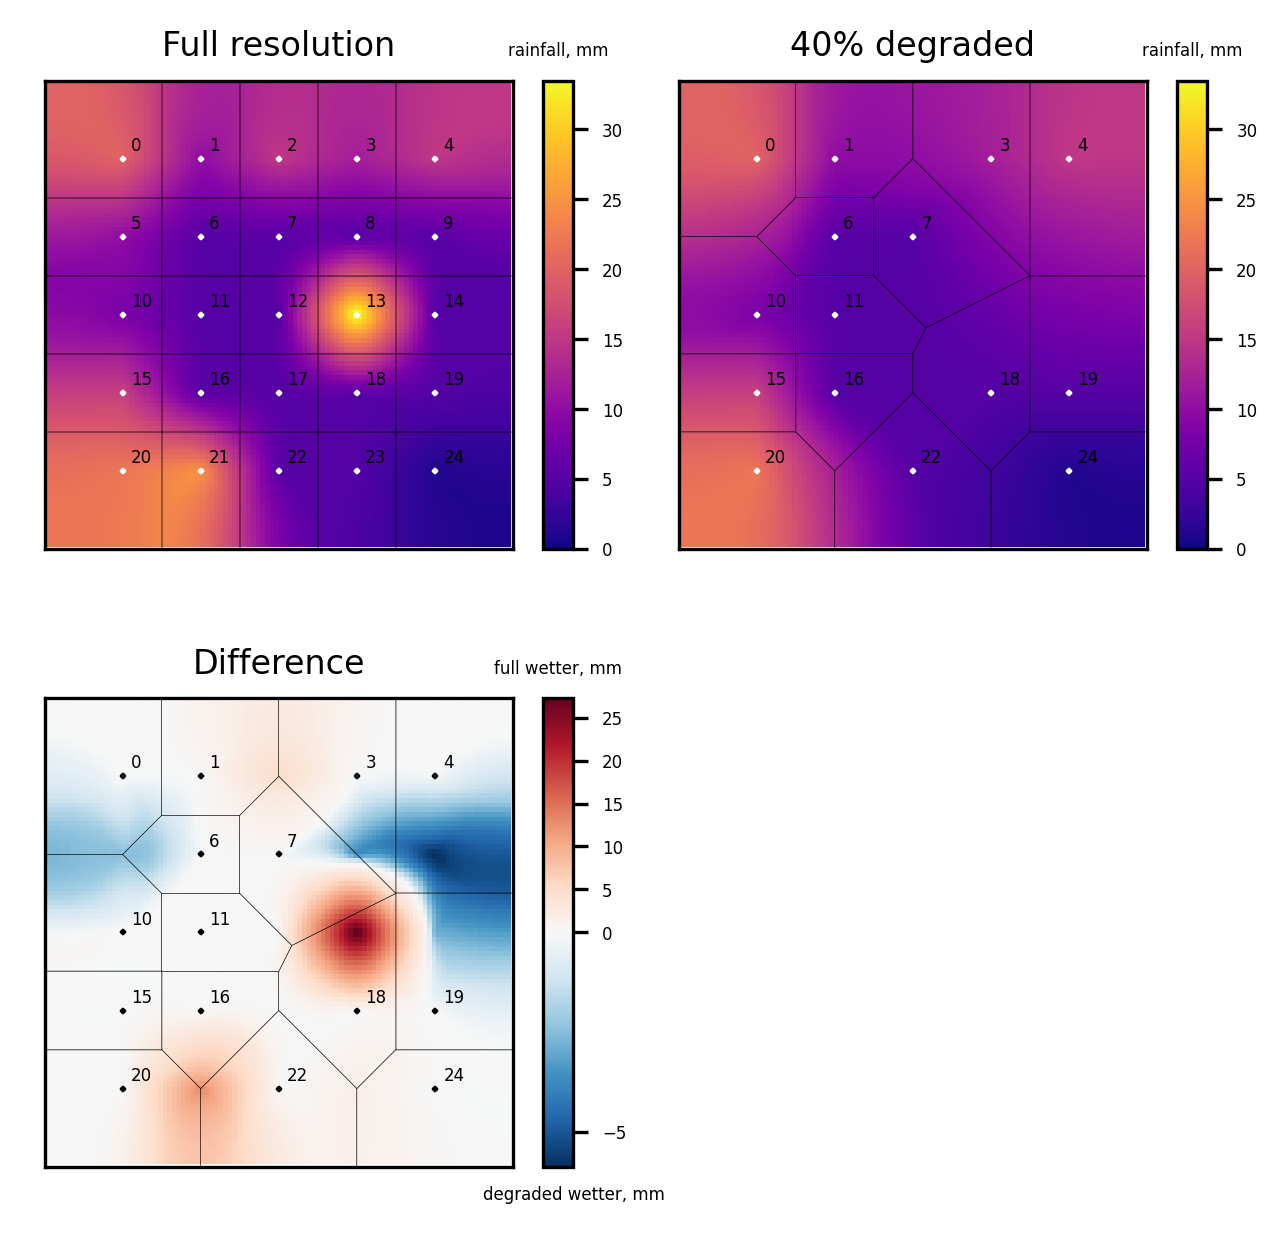

In [15]:
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(2, 2, 1, xticks=[], yticks=[])
drawInterpolation(tensor_fullresolution, samples, ax=ax1, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_fullresolution, ax=ax1)
drawSampleLabels(tensor_fullresolution, ax=ax1, color='w', include_sample_indices=False)
ax1.set_title('Full resolution', fontsize=8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])

ax2 = plt.subplot(2, 2, 2, xticks=[], yticks=[])
drawInterpolation(tensor_60, samples_60, ax=ax2, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_60, ax=ax2)
drawSampleLabels(tensor_60, ax=ax2, color='w', include_sample_indices=-False)
ax2.set_title('40% degraded', fontsize=8)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])

ax3 = plt.subplot(2, 2, 3, xticks=[], yticks=[])
norm_diff = TwoSlopeNorm(vcenter=0, vmin=g_diff.min(), vmax=g_diff.max())
_, cax, _ = drawGrid(g_diff, xs, ys, ax=ax3, norm=norm_diff, cmap=cm.get_cmap('RdBu_r'), cmap_title='full wetter, mm')
drawVoronoiCells(tensor_60, ax=ax3)
drawSampleLabels(tensor_60, ax=ax3, include_sample_indices=False)
ax3.set_title('Difference', fontsize=8)
cax.annotate('degraded wetter, mm', xy=(0.5, 0.0), xycoords='axes points', xytext=(-15, -8), textcoords='offset points', fontsize=4)
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.0])

_ = plt.show()

## Error vectors

Each interpolated point gets its value by weighting the values of a set of sample points -- the exact points and weights being defined by the interpolation algorithm. These weights can be treated like a vector located at the intrerpolation point and pointing towards the sample point, with the weight giving the vector's magnitude.

We can start by plotting the dominant vector, the single vector at each chosen interpolation poin t with the largest magnitude (*i.e.*, the sample with the largest weight). 

INFO:sensor_placement:Applied tensor in 0.00s


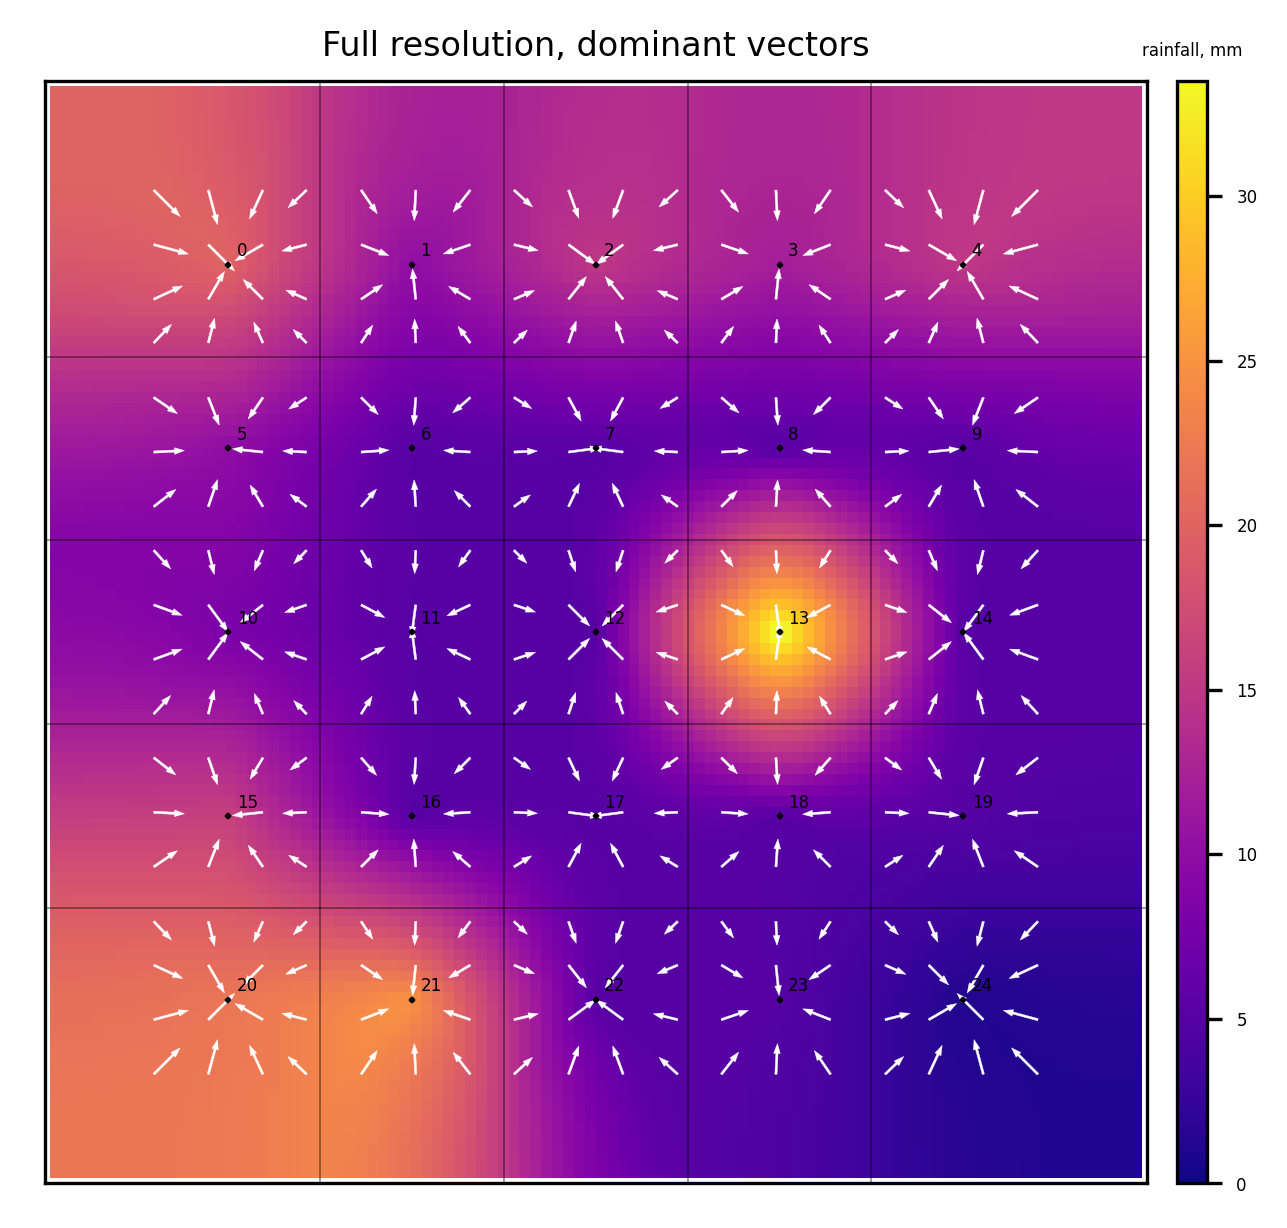

In [16]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

drawInterpolation(tensor_fullresolution, samples, ax=ax, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')

for x in numpy.linspace(0.1, 0.9, 18):
    for y in numpy.linspace(0.1, 0.9, 18):
        #drawWeightVectors(tensor_fullresolution, nearestPointTo(Point(x, y), tensor_fullresolution),
        #                  ax=ax, color='g', radius=0.025, cutoff=0.01)
        drawDominantWeightVector(tensor_fullresolution, nearestPointTo(Point(x, y), tensor_fullresolution),
                                 ax=ax, color='w', radius=0.025, cutoff=0.01, overwrite=False)

drawVoronoiCells(tensor_fullresolution, ax=ax)
drawSampleLabels(tensor_fullresolution, ax=ax, include_sample_indices=False)

ax.set_title('Full resolution, dominant vectors', fontsize=8)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

_ = plt.show()

With the interpolation from the degraded sample, in instead plot all the weight vectors, cutting-out those with very small weights. This still leaves several significant factors in interpolating many sample points.

INFO:sensor_placement:Applied tensor in 0.00s


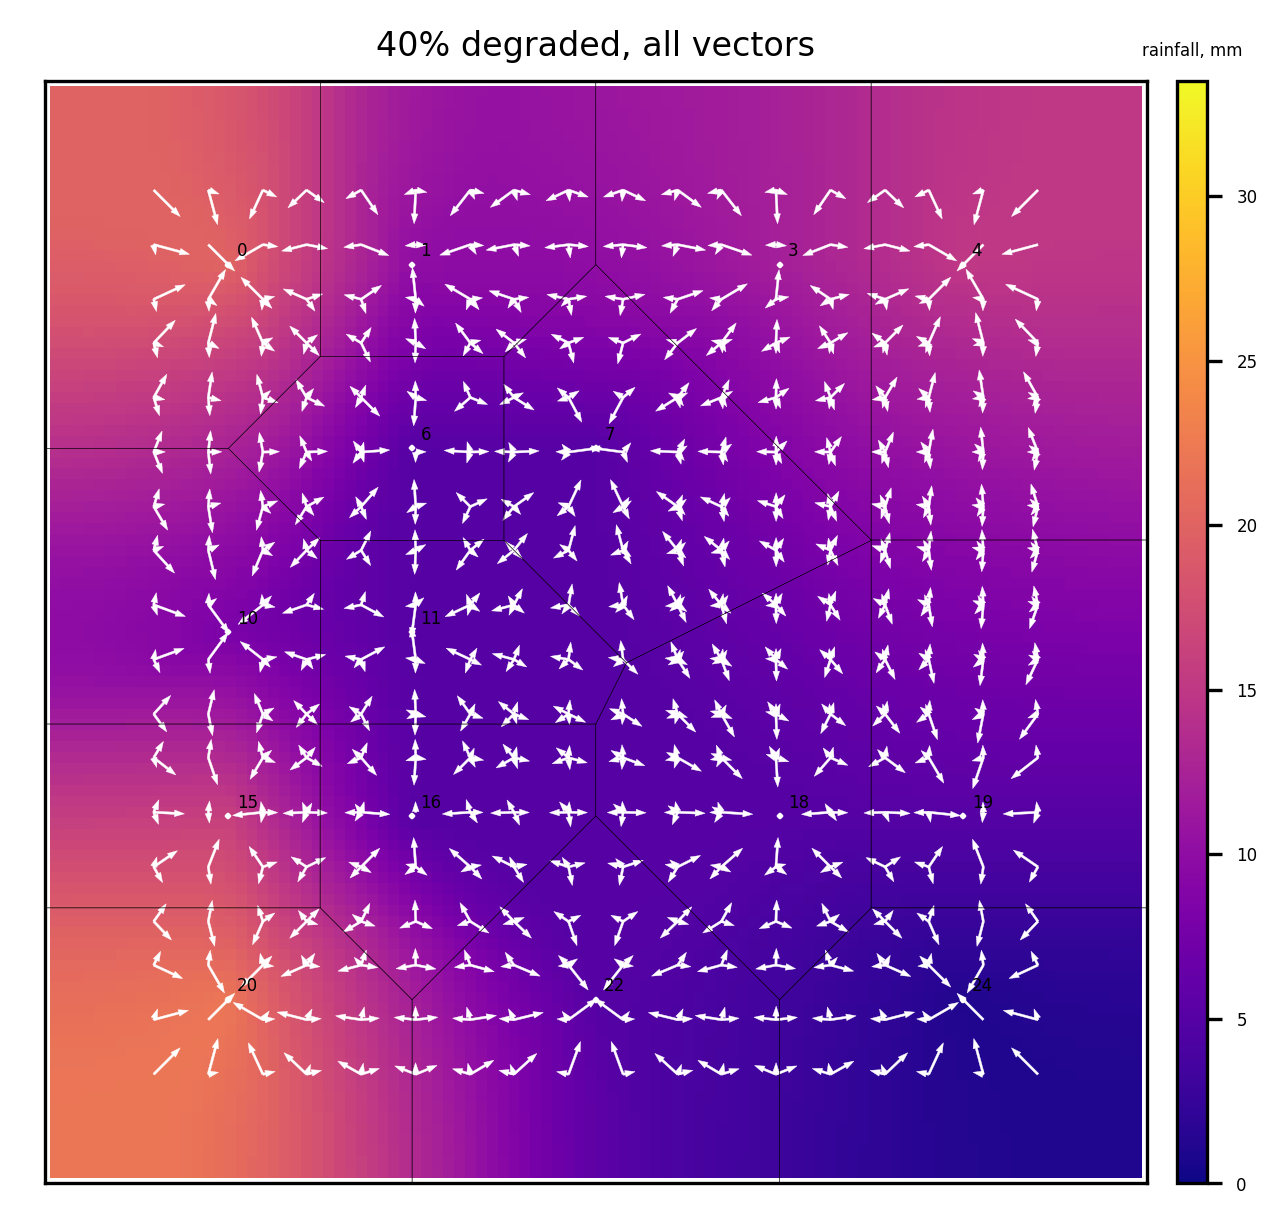

In [17]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

drawInterpolation(tensor_60, samples_60, ax=ax, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')

for x in numpy.linspace(0.1, 0.9, 18):
    for y in numpy.linspace(0.1, 0.9, 18):
        drawWeightVectors(tensor_60, nearestPointTo(Point(x, y), tensor_60),
                          ax=ax, color='w', radius=0.025, cutoff=0.01, overwrite=False)

drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax, color='w', include_sample_indices=False)

ax.set_title('40% degraded, all vectors', fontsize=8)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

_ = plt.show()

We can also resolve all the vectors to construct a single vector that captures the overall effacts of samples on interpolation at a point.

INFO:sensor_placement:Applied tensor in 0.00s


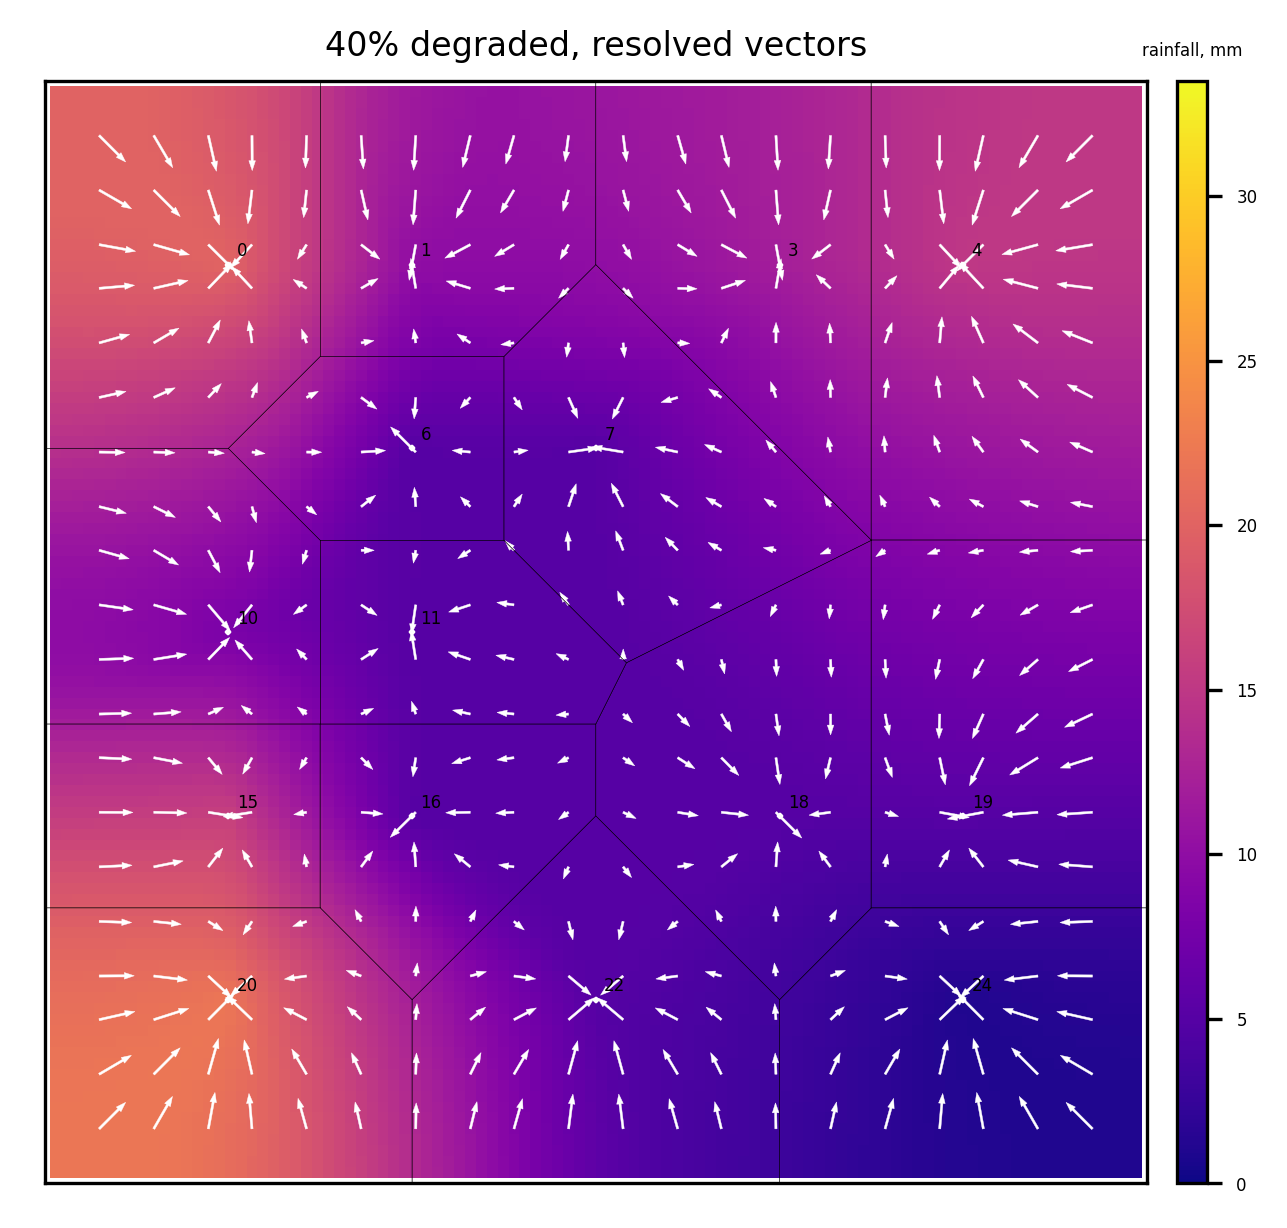

In [19]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

drawInterpolation(tensor_60, samples_60, ax=ax, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
for x in numpy.linspace(0.05, 0.95, 20):
    for y in numpy.linspace(0.05, 0.95, 20):
        drawResolvedVector(tensor_60, nearestPointTo(Point(x, y), tensor_60),
                           ax=ax, color='w', radius=0.025)
drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax, color='w', include_sample_indices=False)
ax.set_title('40% degraded, resolved vectors', fontsize=8)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

_ = plt.show()

INFO:sensor_placement:Applied tensor in 0.00s


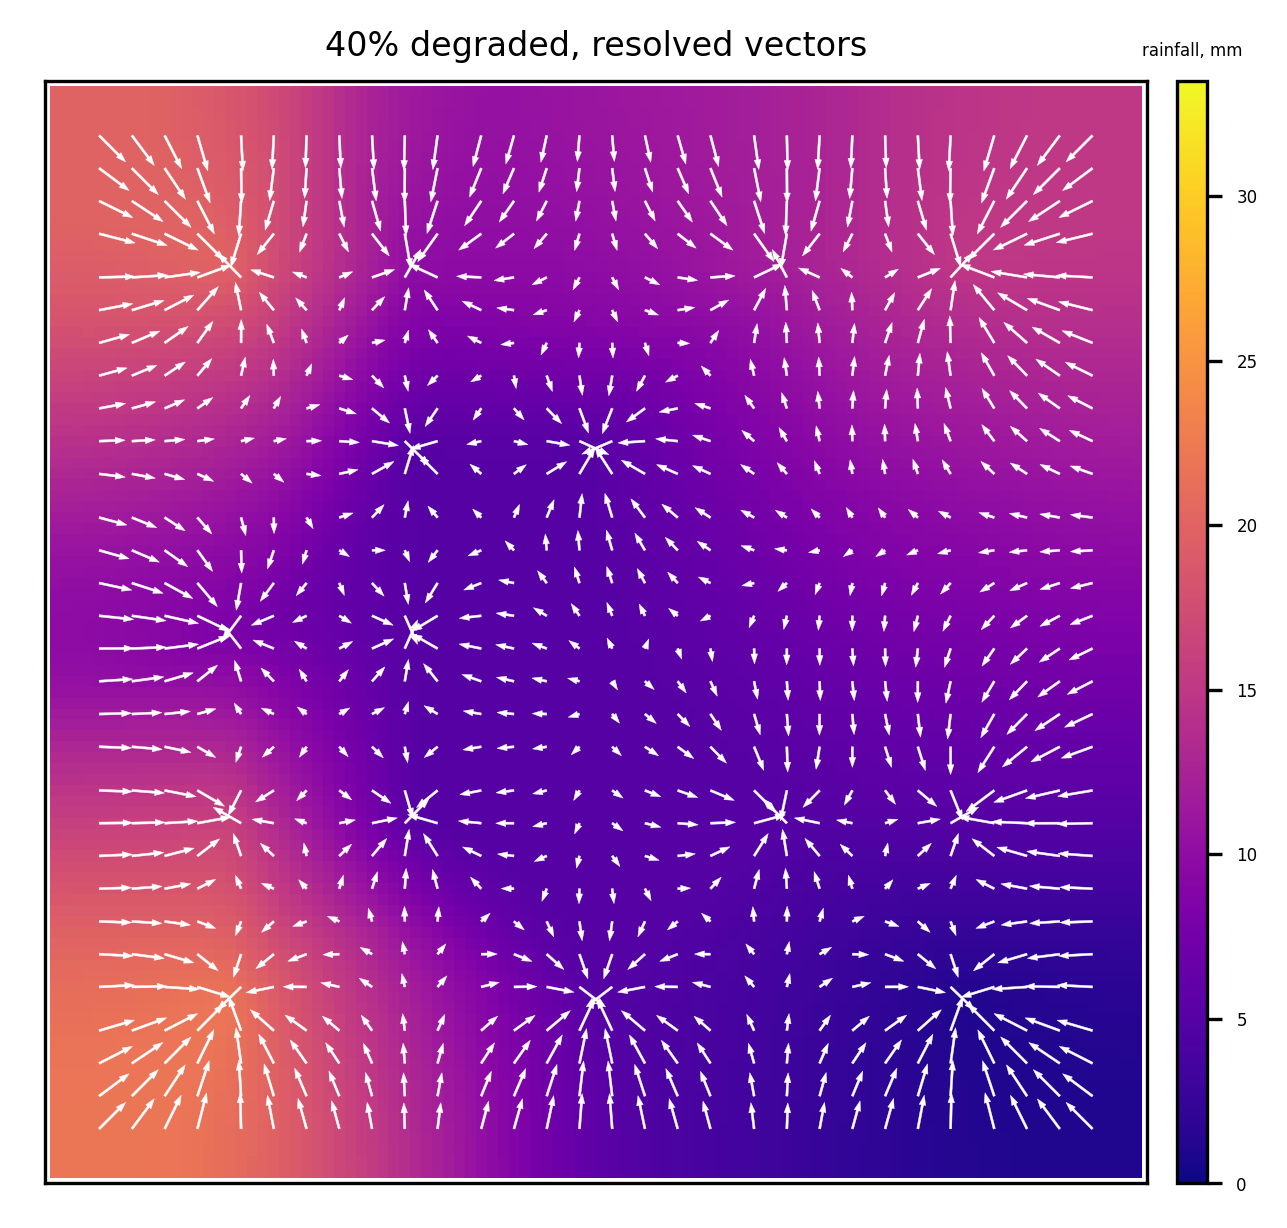

In [20]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

drawInterpolation(tensor_60, samples_60, ax=ax, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
for x in numpy.linspace(0.05, 0.95, 30):
    for y in numpy.linspace(0.05, 0.95, 30):
        drawResolvedVector(tensor_60, nearestPointTo(Point(x, y), tensor_60),
                           ax=ax, color='w', radius=0.025)
#drawVoronoiCells(tensor_60, ax=ax)
#drawSampleLabels(tensor_60, ax=ax)
ax.set_title('40% degraded, resolved vectors', fontsize=8)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

_ = plt.show()

## Pointwise contribution

How much is contributed by a given sample? We can define a metric as the sum of all the non-zero weights.

In [21]:
def contribution(tensor, s):
    si = tensor._voronoi.index.get_loc(s)
    tensor_si = tensor._tensor[:, :, si]
    return numpy.sum(tensor_si)

In [22]:
contributions = []
for s, _ in tensor_60._samples.iterrows():
    contributions.append(contribution(tensor_60, s))
tensor_60._samples['contribution'] = contributions

In [23]:
contribution_60_max = tensor_60._samples[tensor_60._samples['contribution'] == tensor_60._samples['contribution'].max()]
contribution_60_max_sample = contribution_60_max.index[0]
contribution_60_max_point = tensor_60._samples.loc[contribution_60_max_sample].geometry

In [24]:
tensor_59 = deepcopy(tensor_60)
tensor_59.removeSample(contribution_60_max_sample)

In [25]:
contribution_60_max_index = tensor_60._samples.index.get_loc(contribution_60_max_sample)

In [26]:
samples_59 = numpy.delete(samples_60, contribution_60_max_index)

INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


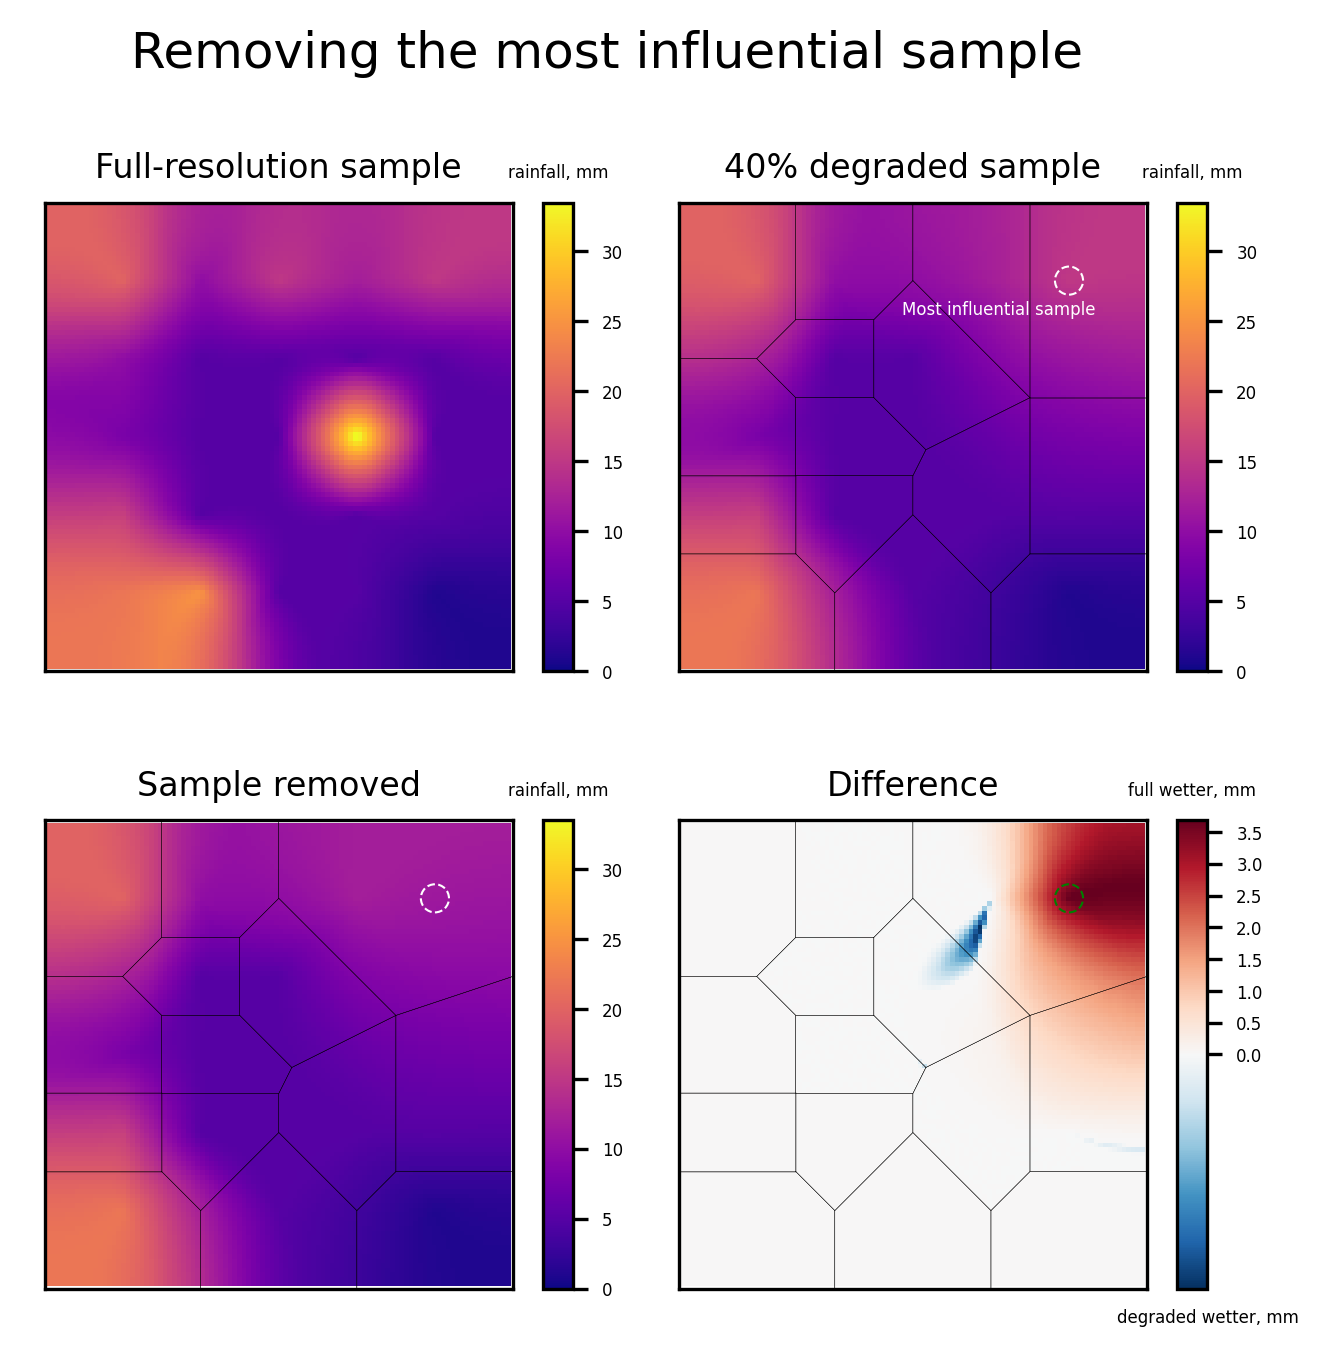

In [27]:
pt = contribution_60_max_point.coords[0]

fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(2, 2, 1, xticks=[], yticks=[])
drawInterpolation(tensor_fullresolution, samples, ax=ax1, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
ax1.set_title('Full-resolution sample', fontsize=8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])

ax2 = plt.subplot(2, 2, 2, xticks=[], yticks=[])
drawInterpolation(tensor_60, samples_60, ax=ax2, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_60, ax=ax2)
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='w')
ax2.add_artist(c)
ax2.annotate('Most influential sample', xy=pt, xycoords='data', xytext=(-40, -8), textcoords='offset points', color='w', fontsize=4)
ax2.set_title('40% degraded sample', fontsize=8)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])

ax3 = plt.subplot(2, 2, 3, xticks=[], yticks=[])
drawInterpolation(tensor_59, samples_59, ax=ax3, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_59, ax=ax3)
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='w')
ax3.add_artist(c)
ax3.set_title('Sample removed', fontsize=8)
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.0])

diff_59 = tensor_60.apply(samples_60) - tensor_59.apply(samples_59)

ax4 = plt.subplot(2, 2, 4, xticks=[], yticks=[])
norm_diff = TwoSlopeNorm(vcenter=0, vmin=diff_59.min(), vmax=diff_59.max())
_, cax, _ = drawGrid(diff_59, tensor_59._xs, tensor_59._ys, ax=ax4, norm=norm_diff, cmap=cm.get_cmap('RdBu_r'), cmap_title='full wetter, mm')
drawVoronoiCells(tensor_59, ax=ax4)
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='g')
ax4.add_artist(c)
cax.annotate('degraded wetter, mm', xy=(0.5, 0.0), xycoords='axes points', xytext=(-15, -8), textcoords='offset points', fontsize=4)
ax4.set_title('Difference', fontsize=8)
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.0])

plt.suptitle('Removing the most influential sample')
_ = plt.show()

Focusing on the top-right corner.

INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


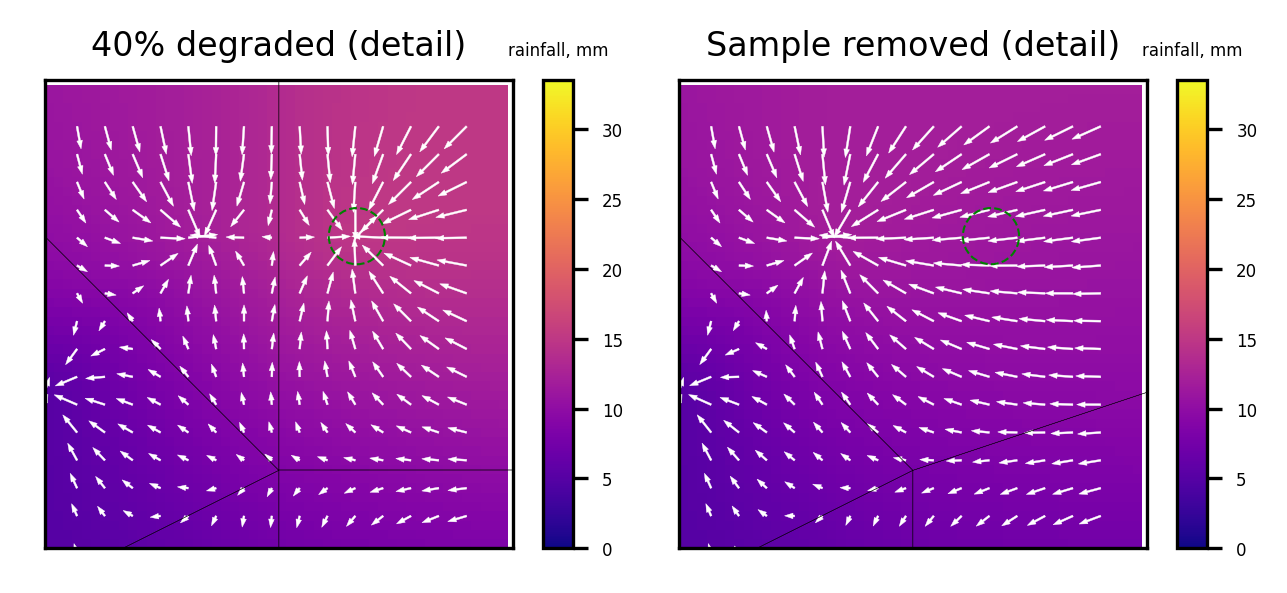

In [46]:
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 2, 1, xticks=[], yticks=[])
drawInterpolation(tensor_60, samples_60, ax=ax1, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
for x in numpy.linspace(0.5, 0.95, 16):
    for y in numpy.linspace(0.5, 0.95, 16):
        drawResolvedVector(tensor_60, nearestPointTo(Point(x, y), tensor_60),
                           ax=ax1, color='w', radius=0.025)
drawVoronoiCells(tensor_60, ax=ax1)
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='g')
ax1.add_artist(c)
ax1.set_title('40% degraded (detail)', fontsize=8)
ax1.set_xlim([0.5, 1.0])
ax1.set_ylim([0.5, 1.0])

ax2 = plt.subplot(1, 2, 2, xticks=[], yticks=[])
drawInterpolation(tensor_59, samples_59, ax=ax2, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
for x in numpy.linspace(0.5, 0.95, 16):
    for y in numpy.linspace(0.5, 0.95, 16):
        drawResolvedVector(tensor_59, nearestPointTo(Point(x, y), tensor_59),
                           ax=ax2, color='w', radius=0.025)
drawVoronoiCells(tensor_59, ax=ax2)
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='g')
ax2.add_artist(c)
ax2.set_title('Sample removed (detail)', fontsize=8)
ax2.set_xlim([0.5, 1.0])
ax2.set_ylim([0.5, 1.0])

_ = plt.show()

We can quantify this change by measuring the change in the direction of the interpolation vectors at a point, in the original (sample) space. 

In [29]:
def cosineDistance(v, w):
    d = numpy.dot(v, w)
    mag_v = numpy.sqrt(numpy.dot(v, v))
    mag_w = numpy.sqrt(numpy.dot(w, w))
    return 1 - d / (mag_v * mag_w)

In [30]:
def computeTurn(tensor, s):
    '''Compute the turning field caused by the removal of the given sample.'''

    # extract grid
    xs, ys = tensor._xs, tensor._ys
    
    # record the index of the sample to be removed
    si = tensor._samples.index.get_loc(s)
    
    # construct the tensor induced by removing s
    reduced = deepcopy(tensor)
    reduced.removeSample(s)
    
    # construct the turning grid
    ts = numpy.zeros((len(xs), len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            v = tensor._tensor[i, j, :]
            w = reduced._tensor[i, j, :]
            
            # extend the reduced vector with a zero at the correct index
            w1 = numpy.append(w, numpy.zeros((1)))
            w1[si + 1:] = w1[si:-1]
            w1[si] = 0.0
            
            # compute the angle
            ts[i, j] = cosineDistance(v, w1)
            
    # return the turning field and the reduced tensor
    return ts, reduced

def drawTurn(ts,
             ax=None, cmap=None, cmap_title=None, norm=None, fontsize=4,
             include_colorbar=True):
    '''Draw the turning of the vector field.'''

    # fill in defaults
    if ax is None:
        ax = plt.gca()
    if cmap is None:
        cmap = cm.get_cmap('viridis')
    if cmap_title is None:
        cmap_title = '$1 - cos \, \\theta$'
    
    # construct a mesh
    xx, yy = numpy.meshgrid(xs, ys)

    # create the colours on the mesh
    if norm is None:
        norm = Normalize(vmin=ts.min(), vmax=ts.max())
    ax.pcolormesh(xx, yy, ts.T, cmap=cmap, norm=norm)
    ax.set_aspect(1.0)

    # add colorbar
    if include_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", 0.1, pad=0.1, sharex=ax)
        matplotlib.colorbar.Colorbar(ax=cax, cmap=cmap, norm=norm)
        cax.tick_params(labelsize=fontsize)
        if cmap_title is not None:
            cax.set_title(cmap_title, fontsize=fontsize)
    else:
        cax = None

    # return the main and colorbar axes, and the norm used,
    return ax, cax, norm

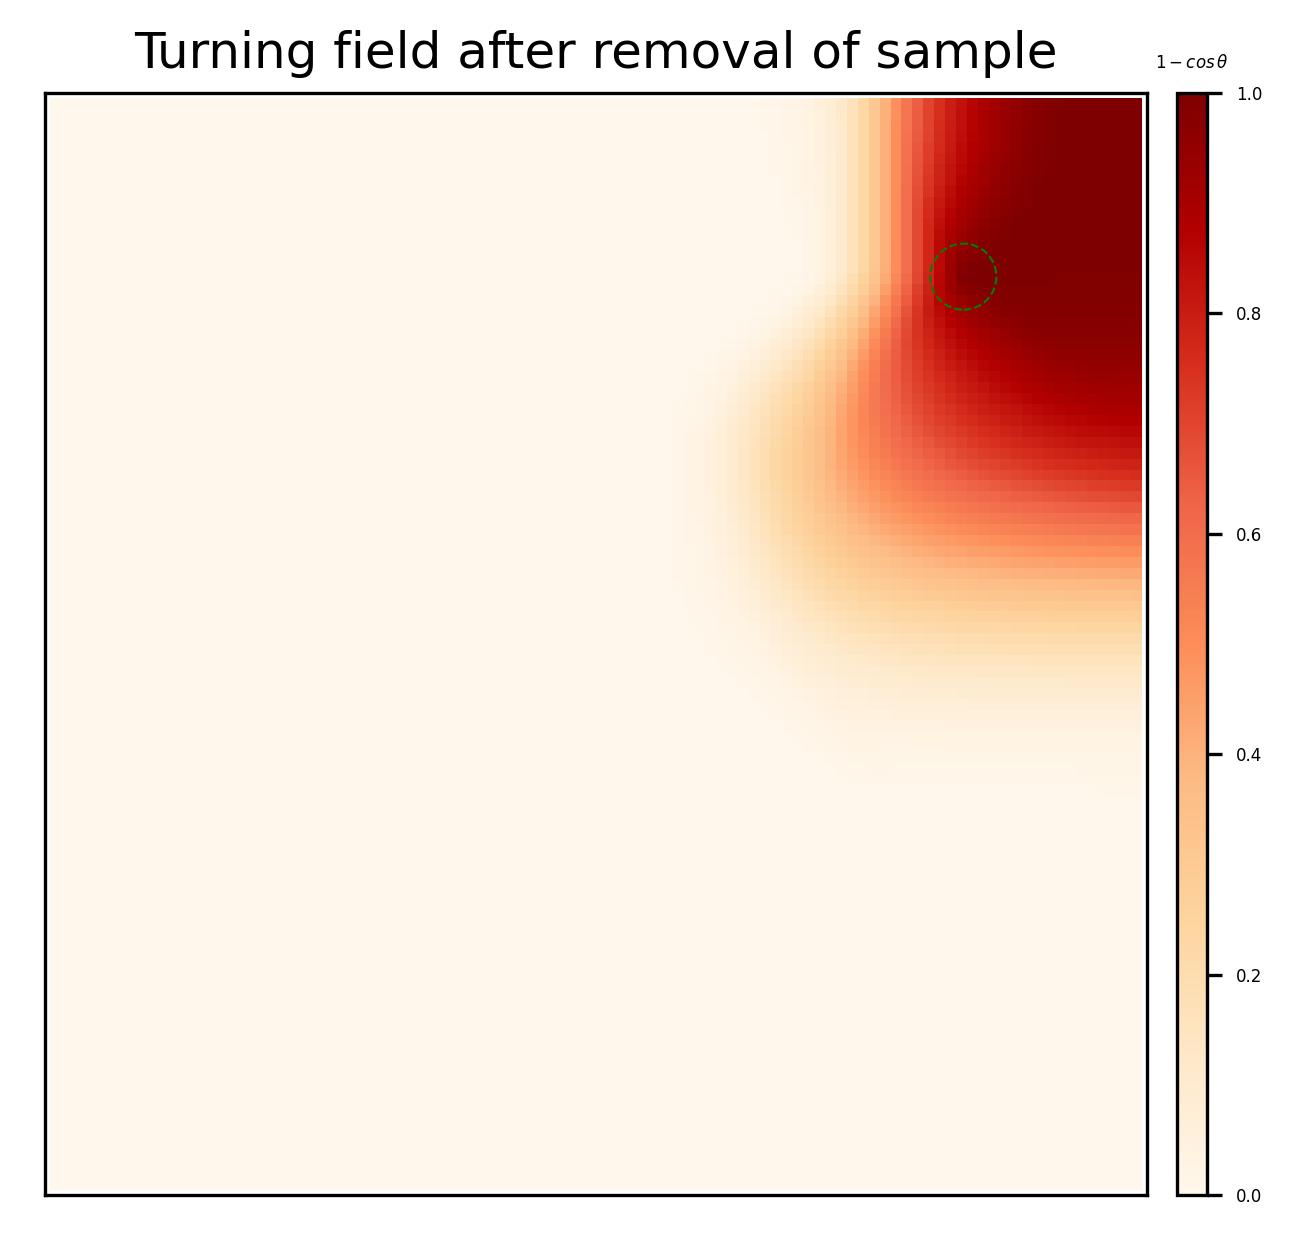

In [31]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
ts, _ = computeTurn(tensor_60, contribution_60_max_sample)
drawTurn(ts, ax=ax, cmap=cm.get_cmap('OrRd'))
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='g')
ax.add_artist(c)
ax.set_title('Turning field after removal of sample')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

 = plt.show()

## Areal contribution

This measures the effect that removing a sample has on each interpolation point individually. To quantify the overall effect of a sample we can compute the distribution of the cosine distance, and then compare this with either a "flat" original distribution or with the derangement caused by a different removal.

In [32]:
h1, e1 = numpy.histogram(ts, bins=50)

In [33]:
contribution_60_other_sample = tensor_60._samples['contribution'].index[9]
contribution_60_other_point = tensor_60._samples.loc[contribution_60_other_sample].geometry

In [34]:
tensor_other = deepcopy(tensor_60)
tensor_other.removeSample(contribution_60_other_sample)

In [35]:
contribution_60_other_index = tensor_60._samples.index.get_loc(contribution_60_other_sample)

In [36]:
samples_other = numpy.delete(samples_60, contribution_60_other_index)

In [37]:
ts2, _ = computeTurn(tensor_60, contribution_60_other_sample)

In [38]:
h2, e2 = numpy.histogram(ts2, bins=50)

In [39]:
len(h1), len(e1)

(50, 51)

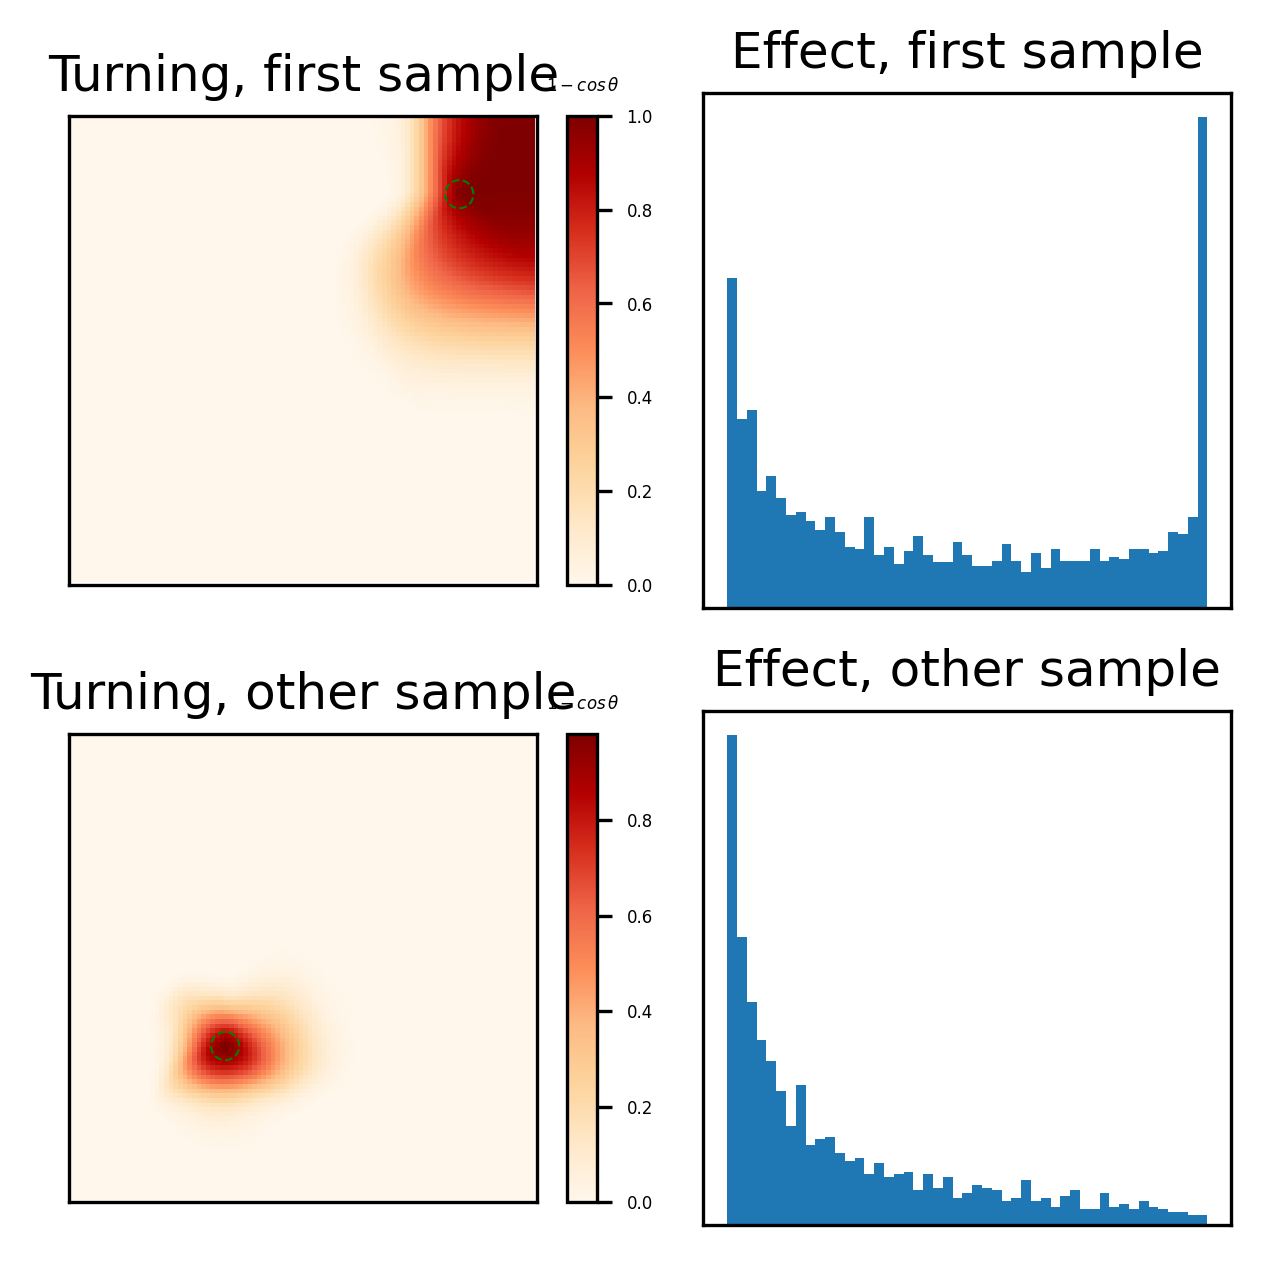

In [40]:
pt2 = contribution_60_other_point.coords[0]

fig = plt.figure(figsize=(5, 5))

ax1 = plt.subplot(2, 2, 1, xticks=[], yticks=[])
drawTurn(ts, ax=ax1, cmap=cm.get_cmap('OrRd'))
c = Circle(pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='g')
ax1.add_artist(c)
ax1.set_title('Turning, first sample')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])

ax2 = plt.subplot(2, 2, 2, xticks=[], yticks=[])
h = deepcopy(h1)
h = h[1:] / ts.size
ax2.bar([1.0 / len(h) * i for i in range(1, len(h) + 1)] , h, width=1.0 / len(h))
ax2.set_title('Effect, first sample')

ax3 = plt.subplot(2, 2, 3, xticks=[], yticks=[])
drawTurn(ts2, ax=ax3, cmap=cm.get_cmap('OrRd'))
c = Circle(pt2, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='g')
ax3.add_artist(c)
ax3.set_title('Turning, other sample')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.0])

ax4 = plt.subplot(2, 2, 4, xticks=[], yticks=[])
h = deepcopy(h2)
h = h[1:] / ts2.size
ax4.bar([1.0 / len(h) * i for i in range(1, len(h) + 1)] , h, width=1.0 / len(h))
ax4.set_title('Effect, other sample')

 = plt.show()

## Impact of errors

Let's now introduce a point error and show its effects. 

In [108]:
percentageError = 1
errorAtSample = 6

errorAt_index = tensor_60._samples.index.get_loc(errorAtSample)
samples_60_error = deepcopy(samples_60)
samples_60_error[errorAt_index] *= (1 + (percentageError / 100))

errorAt_pt = tensor_60._samples.loc[errorAtSample].geometry.coords[0]

In [111]:
g_error = tensor_60.apply(samples_60) - tensor_60.apply(samples_60_error)

INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


INFO:sensor_placement:Applied tensor in 0.00s
INFO:sensor_placement:Applied tensor in 0.00s


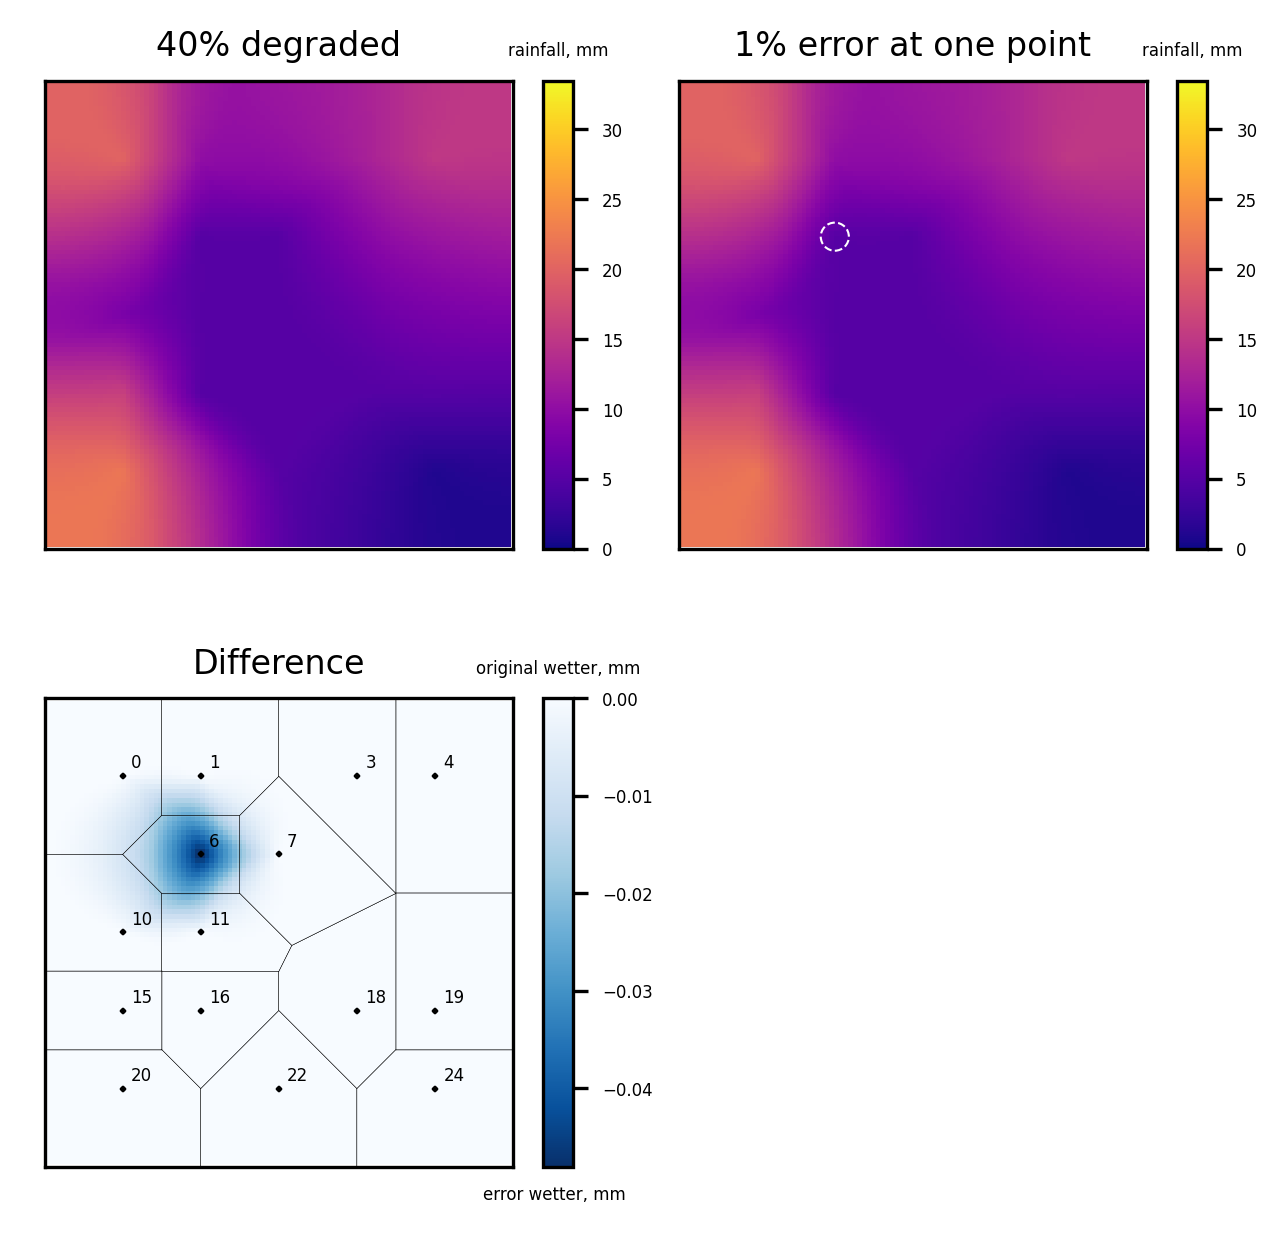

In [115]:
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(2, 2, 1, xticks=[], yticks=[])
drawInterpolation(tensor_60, samples_60, ax=ax1, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
ax1.set_title('40% degraded', fontsize=8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])

ax2 = plt.subplot(2, 2, 2, xticks=[], yticks=[])
drawInterpolation(tensor_60, samples_60_error, ax=ax2, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
#for x in numpy.linspace(0.5, 0.95, 16):
#    for y in numpy.linspace(0.5, 0.95, 16):
#        drawResolvedVector(tensor_60, nearestPointTo(Point(x, y), tensor_59),
#                           ax=ax2, color='w', radius=0.025)
#drawVoronoiCells(tensor_60, ax=ax2)
c = Circle(errorAt_pt, radius=0.03,
           linestyle='--', linewidth=0.5, fill=False, color='w')
ax2.add_artist(c)
ax2.set_title(f'{percentageError}% error at one point', fontsize=8)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])

ax3 = plt.subplot(2, 2, 3, xticks=[], yticks=[])
norm_diff = Normalize(vmin=g_error.min(), vmax=g_error.max())
_, cax, _ = drawGrid(g_error, xs, ys, ax=ax3, norm=norm_diff, cmap=cm.get_cmap('Blues_r'), cmap_title='original wetter, mm')
drawVoronoiCells(tensor_60, ax=ax3)
drawSampleLabels(tensor_60, ax=ax3, include_sample_indices=False)
ax3.set_title('Difference', fontsize=8)
cax.annotate('error wetter, mm', xy=(0.5, 0.0), xycoords='axes points', xytext=(-15, -8), textcoords='offset points', fontsize=4)
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.0])

_ = plt.show()

We want to know how the interpolation vectors spread this error $e$ to the neighbouring points.

If we know the fractional error $e$ that is introduced to the reading, we can 